In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install tensorflow==2.15.0 keras==2.15.0 scikit-learn matplotlib seaborn pillow

print("✓ Installation complete! Please restart the kernel if this is first time installation.")
print("  Go to: Kernel → Restart")

✓ Installation complete! Please restart the kernel if this is first time installation.
  Go to: Kernel → Restart


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.15.0


In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications import EfficientNetB4
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from pathlib import Path

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"✓ GPU Available: {physical_devices[0]}")
    except:
        print("⚠ GPU found but memory growth setting failed")
else:
    print("⚠ No GPU found, using CPU (training will be slower)")

print("✓ Libraries imported successfully")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ Keras version: {keras.__version__}")


⚠ No GPU found, using CPU (training will be slower)
✓ Libraries imported successfully
✓ TensorFlow version: 2.16.2
✓ Keras version: 3.10.0


In [7]:
ZIP_FILE_PATH = r'C:\Users\HP\downloads\Dataset for Crop Pest and Disease Detection.zip'  

# Working directory for extraction and model saving
WORK_DIR = os.path.join(os.getcwd(), 'ccmt_training')
os.makedirs(WORK_DIR, exist_ok=True)

print(f"✓ Working directory: {WORK_DIR}")
print(f"   Current path: {ZIP_FILE_PATH}")
print(f"   File exists: {os.path.exists(ZIP_FILE_PATH)}")

✓ Working directory: C:\Users\HP\ccmt_training
   Current path: C:\Users\HP\downloads\Dataset for Crop Pest and Disease Detection.zip
   File exists: True


In [36]:

# Extract and Use Raw Dataset (Space-Efficient)
# Check if ZIP file exists
if not os.path.exists(ZIP_FILE_PATH):
    print(f"❌ ERROR: ZIP file not found at: {ZIP_FILE_PATH}")
    raise FileNotFoundError(f"Dataset not found: {ZIP_FILE_PATH}")

print(f"✓ Found dataset: {ZIP_FILE_PATH}")
file_size_mb = os.path.getsize(ZIP_FILE_PATH) / (1024 * 1024)
print(f"✓ File size: {file_size_mb:.2f} MB")

# Extract the dataset
extract_path = os.path.join(WORK_DIR, 'ccmt_dataset')
os.makedirs(extract_path, exist_ok=True)

print("\nExtracting dataset (this may take a few minutes)...")
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    total_files = len(zip_ref.namelist())
    print(f"Total files to extract: {total_files}")
    
    for i, file in enumerate(zip_ref.namelist(), 1):
        zip_ref.extract(file, extract_path)
        if i % 1000 == 0:
            print(f"Extracted {i}/{total_files} files...")
    
print(f"✓ Dataset extracted to: {extract_path}")

# ============================================================================
# USE RAW DATASET (Much smaller - 24,881 images)
# ============================================================================
print("\n" + "="*70)
print("USING RAW DATASET (Space-Efficient)")
print("="*70)

# Point to Raw Data directory
raw_data_dir = os.path.join(extract_path, 'Dataset for Crop Pest and Disease Detection', 
                            'Raw Data', 'CCMT Dataset')

print(f"\n✓ Using raw dataset from: {raw_data_dir}")

# This directory already has the proper structure:
# CCMT Dataset/
# ├── Cashew/
# ├── Cassava/
# ├── Maize/
# └── Tomato/

# Each crop folder contains disease class folders directly
data_dir = raw_data_dir

# Count classes and images
crops = ['Cashew', 'Cassava', 'Maize', 'Tomato']
class_info = {}
total_images = 0

print(f"\n📊 Scanning raw dataset...")
for crop in crops:
    crop_dir = os.path.join(data_dir, crop)
    
    if not os.path.exists(crop_dir):
        continue
    
    disease_classes = sorted([d for d in os.listdir(crop_dir) 
                             if os.path.isdir(os.path.join(crop_dir, d))])
    
    for disease_class in disease_classes:
        class_path = os.path.join(crop_dir, disease_class)
        num_images = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        class_name = f"{crop}_{disease_class}"
        class_info[class_name] = num_images
        total_images += num_images

print("\n" + "="*70)
print("✓ RAW DATASET READY")
print("="*70)
print(f"\n📊 Dataset Statistics:")
print(f"   - Total Crops: 4 (Cashew, Cassava, Maize, Tomato)")
print(f"   - Total Classes: {len(class_info)}")
print(f"   - Total Images: {total_images:,}")
print(f"   - Average images per class: {total_images // len(class_info) if class_info else 0}")

print(f"\n📋 Class Distribution:")
for i, (class_name, count) in enumerate(sorted(class_info.items()), 1):
    print(f"   {i:2d}. {class_name:40s} : {count:5d} images")

print(f"\n✓ Dataset is ready for training!")
print(f"💡 Using raw data = faster training, less disk space!")

class_folders = list(class_info.keys())

✓ Found dataset: C:\Users\HP\downloads\Dataset for Crop Pest and Disease Detection.zip
✓ File size: 8051.62 MB

Extracting dataset (this may take a few minutes)...
Total files to extract: 130472
Extracted 1000/130472 files...
Extracted 2000/130472 files...
Extracted 3000/130472 files...
Extracted 4000/130472 files...
Extracted 5000/130472 files...
Extracted 6000/130472 files...
Extracted 7000/130472 files...
Extracted 8000/130472 files...
Extracted 9000/130472 files...
Extracted 10000/130472 files...
Extracted 11000/130472 files...
Extracted 12000/130472 files...
Extracted 13000/130472 files...
Extracted 14000/130472 files...
Extracted 15000/130472 files...
Extracted 16000/130472 files...
Extracted 17000/130472 files...
Extracted 18000/130472 files...
Extracted 19000/130472 files...
Extracted 20000/130472 files...
Extracted 21000/130472 files...
Extracted 22000/130472 files...
Extracted 23000/130472 files...
Extracted 24000/130472 files...
Extracted 25000/130472 files...
Extracted 2600

In [15]:

# DEEPER SEARCH: Check inside the nested folders

import os

base_dir = os.path.join(extract_path, 'Dataset for Crop Pest and Disease Detection')

# Check CCMT Dataset-Augmented
augmented_dir = os.path.join(base_dir, 'CCMT Dataset-Augmented')
raw_dir = os.path.join(base_dir, 'Raw Data')

print("="*70)
print("CHECKING: CCMT Dataset-Augmented")
print("="*70)
if os.path.exists(augmented_dir):
    contents = os.listdir(augmented_dir)
    print(f"Contents ({len(contents)} items):")
    for item in contents:
        item_path = os.path.join(augmented_dir, item)
        if os.path.isdir(item_path):
            try:
                num_items = len(os.listdir(item_path))
                # Check if it contains images or more folders
                sub_items = os.listdir(item_path)[:5]
                print(f"  📁 {item} ({num_items} items)")
                print(f"      Sample contents: {sub_items}")
            except:
                print(f"  📁 {item}")
        else:
            print(f"  📄 {item}")

print("\n" + "="*70)
print("CHECKING: Raw Data")
print("="*70)
if os.path.exists(raw_dir):
    contents = os.listdir(raw_dir)
    print(f"Contents ({len(contents)} items):")
    for item in contents:
        item_path = os.path.join(raw_dir, item)
        if os.path.isdir(item_path):
            try:
                num_items = len(os.listdir(item_path))
                sub_items = os.listdir(item_path)[:5]
                print(f"  📁 {item} ({num_items} items)")
                print(f"      Sample contents: {sub_items}")
            except:
                print(f"  📁 {item}")
        else:
            print(f"  📄 {item}")

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)
print("The CCMT dataset typically has:")
print("  - 'CCMT Dataset-Augmented' folder with 102,976 augmented images")
print("  - 'Raw Data' folder with 24,881 raw images")
print("\nFor training, we should use the 'CCMT Dataset-Augmented' folder")
print("as it contains more data with augmentations already applied.")

CHECKING: CCMT Dataset-Augmented
Contents (4 items):
  📁 Cashew (2 items)
      Sample contents: ['test_set', 'train_set']
  📁 Cassava (2 items)
      Sample contents: ['test_set', 'train_set']
  📁 Maize (2 items)
      Sample contents: ['test_set', 'train_set']
  📁 Tomato (2 items)
      Sample contents: ['test_set', 'train_set']

CHECKING: Raw Data
Contents (1 items):
  📁 CCMT Dataset (4 items)
      Sample contents: ['Cashew', 'Cassava', 'Maize', 'Tomato']

RECOMMENDATION
The CCMT dataset typically has:
  - 'CCMT Dataset-Augmented' folder with 102,976 augmented images
  - 'Raw Data' folder with 24,881 raw images

For training, we should use the 'CCMT Dataset-Augmented' folder
as it contains more data with augmentations already applied.


In [17]:
# ============================================================================
# CHECK DISEASE CLASSES STRUCTURE
# ============================================================================
import os

augmented_dir = os.path.join(extract_path, 'Dataset for Crop Pest and Disease Detection', 'CCMT Dataset-Augmented')

# Check inside Cashew/train_set to see the disease classes
cashew_train = os.path.join(augmented_dir, 'Cashew', 'train_set')

print("="*70)
print("DISEASE CLASSES IN: Cashew/train_set")
print("="*70)
if os.path.exists(cashew_train):
    classes = os.listdir(cashew_train)
    print(f"Found {len(classes)} disease classes:")
    for cls in classes:
        cls_path = os.path.join(cashew_train, cls)
        if os.path.isdir(cls_path):
            num_images = len([f for f in os.listdir(cls_path) 
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  - {cls}: {num_images} images")

# Check Cassava
cassava_train = os.path.join(augmented_dir, 'Cassava', 'train_set')
print("\n" + "="*70)
print("DISEASE CLASSES IN: Cassava/train_set")
print("="*70)
if os.path.exists(cassava_train):
    classes = os.listdir(cassava_train)
    print(f"Found {len(classes)} disease classes:")
    for cls in classes:
        cls_path = os.path.join(cassava_train, cls)
        if os.path.isdir(cls_path):
            num_images = len([f for f in os.listdir(cls_path) 
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  - {cls}: {num_images} images")

print("\n" + "="*70)
print("DATASET STRUCTURE CONFIRMED")
print("="*70)
print("""
Your dataset structure is:
CCMT Dataset-Augmented/
├── Cashew/
│   ├── train_set/
│   │   ├── Disease_Class_1/
│   │   ├── Disease_Class_2/
│   │   └── ...
│   └── test_set/
│       ├── Disease_Class_1/
│       └── ...
├── Cassava/
│   ├── train_set/
│   └── test_set/
├── Maize/
│   ├── train_set/
│   └── test_set/
└── Tomato/
    ├── train_set/
    └── test_set/

We need to MERGE all crops' train_set folders into one directory
for the training pipeline to work correctly.
""")

DISEASE CLASSES IN: Cashew/train_set
Found 5 disease classes:
  - anthracnose3102: 3102 images
  - gumosis1714: 1714 images
  - healthy5877: 5877 images
  - leaf miner3466: 3466 images
  - red rust4751: 4751 images

DISEASE CLASSES IN: Cassava/train_set
Found 6 disease classes:
  - bacterial blight: 5954 images
  - bacterial blight3241: 3241 images
  - brown spot: 3250 images
  - green mite: 3246 images
  - healthy: 2271 images
  - mosaic: 2250 images

DATASET STRUCTURE CONFIRMED

Your dataset structure is:
CCMT Dataset-Augmented/
├── Cashew/
│   ├── train_set/
│   │   ├── Disease_Class_1/
│   │   ├── Disease_Class_2/
│   │   └── ...
│   └── test_set/
│       ├── Disease_Class_1/
│       └── ...
├── Cassava/
│   ├── train_set/
│   └── test_set/
├── Maize/
│   ├── train_set/
│   └── test_set/
└── Tomato/
    ├── train_set/
    └── test_set/

We need to MERGE all crops' train_set folders into one directory
for the training pipeline to work correctly.



In [38]:
# Training Configuration
CONFIG = {
    'img_size': (224, 224),
    'batch_size': 32,
    'epochs': 20,  # Set to 20 epochs
    'learning_rate': 0.001,
    'validation_split': 0.2,
    'test_split': 0.1,
    'num_classes': len(class_folders),
    'model_name': 'ccmt_crop_disease_model',
    'checkpoint_dir': os.path.join(WORK_DIR, 'checkpoints'),
    'final_model_dir': os.path.join(WORK_DIR, 'final_model')
}

# Create directories
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
os.makedirs(CONFIG['final_model_dir'], exist_ok=True)

# Save configuration
config_to_save = {k: str(v) if isinstance(v, (Path, tuple)) else v 
                  for k, v in CONFIG.items()}
with open(os.path.join(CONFIG['checkpoint_dir'], 'config.json'), 'w') as f:
    json.dump(config_to_save, f, indent=2)
    
print("✓ Configuration saved:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

✓ Configuration saved:
   img_size: (224, 224)
   batch_size: 32
   epochs: 20
   learning_rate: 0.001
   validation_split: 0.2
   test_split: 0.1
   num_classes: 22
   model_name: ccmt_crop_disease_model
   checkpoint_dir: C:\Users\HP\ccmt_training\checkpoints
   final_model_dir: C:\Users\HP\ccmt_training\final_model


In [58]:
# To delete messey directory and datasets
# CLEANUP AND REBUILD

import shutil

# Delete the old unified dataset
unified_dir = os.path.join(WORK_DIR, 'unified_raw_dataset')
if os.path.exists(unified_dir):
    print(f"Deleting old unified dataset: {unified_dir}")
    shutil.rmtree(unified_dir)
    print("✓ Old dataset deleted")

print("Now re-run Cell 6 to create a fresh, clean dataset")

Deleting old unified dataset: C:\Users\HP\ccmt_training\unified_raw_dataset
✓ Old dataset deleted
Now re-run Cell 6 to create a fresh, clean dataset


In [66]:
#6: Create Clean Unified Dataset 

import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("Creating clean unified dataset from raw data...")
print("="*70)

# IMPORTANT: Use the raw data source, not the unified directory
source_data_dir = os.path.join(extract_path, 'Dataset for Crop Pest and Disease Detection', 
                               'Raw Data', 'CCMT Dataset')

print(f"Source: {source_data_dir}")
print(f"Source exists: {os.path.exists(source_data_dir)}")

# Create unified directory
unified_dir = os.path.join(WORK_DIR, 'unified_raw_dataset')

# Delete if exists to start fresh
if os.path.exists(unified_dir):
    print("Removing old unified dataset...")
    shutil.rmtree(unified_dir)

os.makedirs(unified_dir, exist_ok=True)

crops = ['Cashew', 'Cassava', 'Maize', 'Tomato']
total_valid = 0
total_skipped = 0

for crop in crops:
    crop_dir = os.path.join(source_data_dir, crop)  # Read from source_data_dir
    
    if not os.path.exists(crop_dir):
        print(f"⚠ Warning: {crop} directory not found at {crop_dir}")
        continue
    
    disease_classes = sorted([d for d in os.listdir(crop_dir) 
                             if os.path.isdir(os.path.join(crop_dir, d))])
    
    print(f"\nProcessing {crop} ({len(disease_classes)} disease classes)...")
    
    for disease_class in disease_classes:
        source_dir = os.path.join(crop_dir, disease_class)
        unified_class_name = f"{crop}_{disease_class}"
        dest_dir = os.path.join(unified_dir, unified_class_name)
        
        os.makedirs(dest_dir, exist_ok=True)
        
        # Copy only valid images
        print(f"  {unified_class_name}...", end='', flush=True)
        valid_count = 0
        corrupt_count = 0
        
        source_files = os.listdir(source_dir)
        
        for img_file in source_files:
            if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            
            src_path = os.path.join(source_dir, img_file)
            dest_path = os.path.join(dest_dir, img_file)
            
            # Verify image is valid before copying
            try:
                # Open and verify
                img = Image.open(src_path)
                img.verify()
                img.close()
                
                # Actually load to ensure it's not truncated
                img = Image.open(src_path)
                img.load()
                img.close()
                
                # Copy if valid
                shutil.copy2(src_path, dest_path)
                valid_count += 1
                total_valid += 1
            except Exception as e:
                corrupt_count += 1
                total_skipped += 1
        
        print(f" {valid_count} images", end='')
        if corrupt_count > 0:
            print(f" ({corrupt_count} corrupted skipped)", end='')
        print(" ✓")

# Update data_dir to unified directory
data_dir = unified_dir

print("\n" + "="*70)
print("✓ CLEAN UNIFIED DATASET CREATED")
print("="*70)
print(f"Total valid images copied: {total_valid:,}")
print(f"Total corrupted skipped: {total_skipped}")
print(f"Dataset location: {data_dir}")

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3],
    validation_split=CONFIG['validation_split']
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=CONFIG['validation_split']
)

# Create generators
print("\nCreating data generators...")
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=CONFIG['img_size'],
    batch_size=CONFIG['batch_size'],
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=CONFIG['img_size'],
    batch_size=CONFIG['batch_size'],
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Save class indices
with open(os.path.join(CONFIG['final_model_dir'], 'class_indices.json'), 'w') as f:
    json.dump(train_generator.class_indices, f, indent=2)

print("\n" + "="*70)
print(" DATA GENERATORS READY")
print("="*70)
print(f"   - Training samples: {train_generator.samples:,}")
print(f"   - Validation samples: {validation_generator.samples:,}")
print(f"   - Number of classes: {len(train_generator.class_indices)}")
print(f"   - Steps per epoch: {train_generator.samples // CONFIG['batch_size']}")
print(f"   - Validation steps: {validation_generator.samples // CONFIG['batch_size']}")
print("\n All corrupted images excluded - ready for clean training!")

Creating clean unified dataset from raw data...
Source: C:\Users\HP\ccmt_training\ccmt_dataset\Dataset for Crop Pest and Disease Detection\Raw Data\CCMT Dataset
Source exists: True
Removing old unified dataset...

Processing Cashew (5 disease classes)...
  Cashew_anthracnose... 1729 images ✓
  Cashew_gumosis... 392 images ✓
  Cashew_healthy... 1368 images ✓
  Cashew_leaf miner... 1378 images ✓
  Cashew_red rust... 1682 images ✓

Processing Cassava (5 disease classes)...
  Cassava_bacterial blight... 2614 images ✓
  Cassava_brown spot... 1481 images ✓
  Cassava_green mite... 1015 images ✓
  Cassava_healthy... 1193 images ✓
  Cassava_mosaic... 1205 images ✓

Processing Maize (7 disease classes)...
  Maize_fall armyworm... 285 images ✓
  Maize_grasshoper... 673 images ✓
  Maize_healthy... 204 images (4 corrupted skipped) ✓
  Maize_leaf beetle... 933 images (15 corrupted skipped) ✓
  Maize_leaf blight... 990 images (16 corrupted skipped) ✓
  Maize_leaf spot... 1239 images (20 corrupted ski

In [88]:
#7: Build Model (Optimized for Small Dataset)

from tensorflow.keras.applications import MobileNetV2

def build_model(num_classes, img_size):
    """
    Build model optimized for smaller datasets using MobileNetV2
    """
    # Use MobileNetV2 (much lighter than EfficientNetB4)
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(*img_size, 3),
        alpha=1.0  # Width multiplier
    )
    
    # Freeze only bottom 80% of base model (more flexibility)
    base_model.trainable = True
    for layer in base_model.layers[:-30]:  # Unfreeze top 30 layers
        layer.trainable = False
    
    # Build model
    inputs = keras.Input(shape=(*img_size, 3))
    
    # Data augmentation layers (built-in)
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.2)(x)
    
    # Base model
    x = base_model(x, training=True)
    
    # Simpler classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    return model, base_model

# Build the model
print("Building optimized model for crop disease detection...")
model, base_model = build_model(CONFIG['num_classes'], CONFIG['img_size'])

# Calculate class weights
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

# Compile with higher learning rate since we have more trainable params
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
        keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')
    ]
)

print("✓ Model built successfully")
print(f"\n📊 Model Summary:")
model.summary()

print(f"\n📈 Model Parameters:")
trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_count = sum([tf.size(w).numpy() for w in model.non_trainable_weights])

print(f"   - Total parameters: {trainable_count + non_trainable_count:,}")
print(f"   - Trainable parameters: {trainable_count:,}")
print(f"   - Non-trainable parameters: {non_trainable_count:,}")

print("\n✅ Optimizations:")
print("   - Using MobileNetV2 (lighter, faster)")
print("   - Top 30 layers unfrozen (better for small datasets)")
print("   - Built-in data augmentation")
print("   - Simpler classification head")
print("   - Class weights for imbalance")

Building optimized model for crop disease detection...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step
✓ Model built successfully

📊 Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,622,678 (10.00 MB)

 Trainable params: 1,890,582 (7.21 MB)

 Non-trainable params: 732,096 (2.79 MB)


📈 Model Parameters:
   - Total parameters: 2,622,678
   - Trainable parameters: 1,890,582
   - Non-trainable parameters: 732,096

✅ Optimizations:
   - Using MobileNetV2 (lighter, faster)
   - Top 30 layers unfrozen (better for small datasets)
   - Built-in data augmentation
   - Simpler classification head
   - Class weights for imbalance


In [90]:
#8 Checkpoint callback - saves best model and enables resume
checkpoint_path = os.path.join(CONFIG['checkpoint_dir'], 'best_model.keras')
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Increased patience for 20 epochs
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,  # Reduced patience for 20 epochs
    min_lr=1e-7,
    verbose=1
)

# CSV Logger for training history
csv_logger = CSVLogger(
    os.path.join(CONFIG['checkpoint_dir'], 'training_log.csv'),
    append=True
)

callbacks = [checkpoint_callback, early_stopping, reduce_lr, csv_logger]

# Check if checkpoint exists (for resuming training)
initial_epoch = 0
if os.path.exists(checkpoint_path):
    print(f"\n Found existing checkpoint: {checkpoint_path}")
    response = input("Resume training from checkpoint? (yes/no): ").strip().lower()
    
    if response == 'yes':
        print("Loading checkpoint...")
        model = keras.models.load_model(checkpoint_path)
        
        # Try to determine last epoch from CSV log
        log_file = os.path.join(CONFIG['checkpoint_dir'], 'training_log.csv')
        if os.path.exists(log_file):
            import pandas as pd
            log_df = pd.read_csv(log_file)
            initial_epoch = len(log_df)
            print(f" Resuming from epoch {initial_epoch}")
        else:
            print("Checkpoint loaded, starting from epoch 0")
    else:
        print("Starting fresh training...")
        initial_epoch = 0
else:
    print("No checkpoint found, starting fresh training")

print(f"\n✓ Callbacks configured:")
print(f"   - Model checkpoint: {checkpoint_path}")
print(f"   - Early stopping patience: 5 epochs")
print(f"   - Learning rate reduction: enabled")
print(f"   - Training will resume automatically if interrupted")


 Found existing checkpoint: C:\Users\HP\ccmt_training\checkpoints\best_model.keras


Resume training from checkpoint? (yes/no):  no


Starting fresh training...

✓ Callbacks configured:
   - Model checkpoint: C:\Users\HP\ccmt_training\checkpoints\best_model.keras
   - Early stopping patience: 5 epochs
   - Learning rate reduction: enabled
   - Training will resume automatically if interrupted



TRAINING: Single-Stage (No transfer learning split)
Training for 20 epochs

Epoch 1/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3564 - loss: 2.0626 - top_3_accuracy: 0.6068 - top_5_accuracy: 0.7181
Epoch 1: val_accuracy improved from -inf to 0.48844, saving model to C:\Users\HP\ccmt_training\checkpoints\best_model.keras
629/629 ━━━━━━━━━━━━━━━━━━━━ 2494s 3s/step - accuracy: 0.3566 - loss: 2.0617 - top_3_accuracy: 0.6070 - top_5_accuracy: 0.7184 - val_accuracy: 0.4884 - val_loss: 3.2894 - val_top_3_accuracy: 0.8050 - val_top_5_accuracy: 0.9003 - learning_rate: 5.0000e-04
Epoch 2/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6295 - loss: 0.9907 - top_3_accuracy: 0.9004 - top_5_accuracy: 0.9582
Epoch 2: val_accuracy improved from 0.48844 to 0.57436, saving model to C:\Users\HP\ccmt_training\checkpoints\best_model.keras
629/629 ━━━━━━━━━━━━━━━━━━━━ 1651s 3s/step - accuracy: 0.6295 - loss: 0.9906 - top_3_accuracy: 0.9004 - top_5_accuracy: 0.9582 - val_accuracy: 0.57

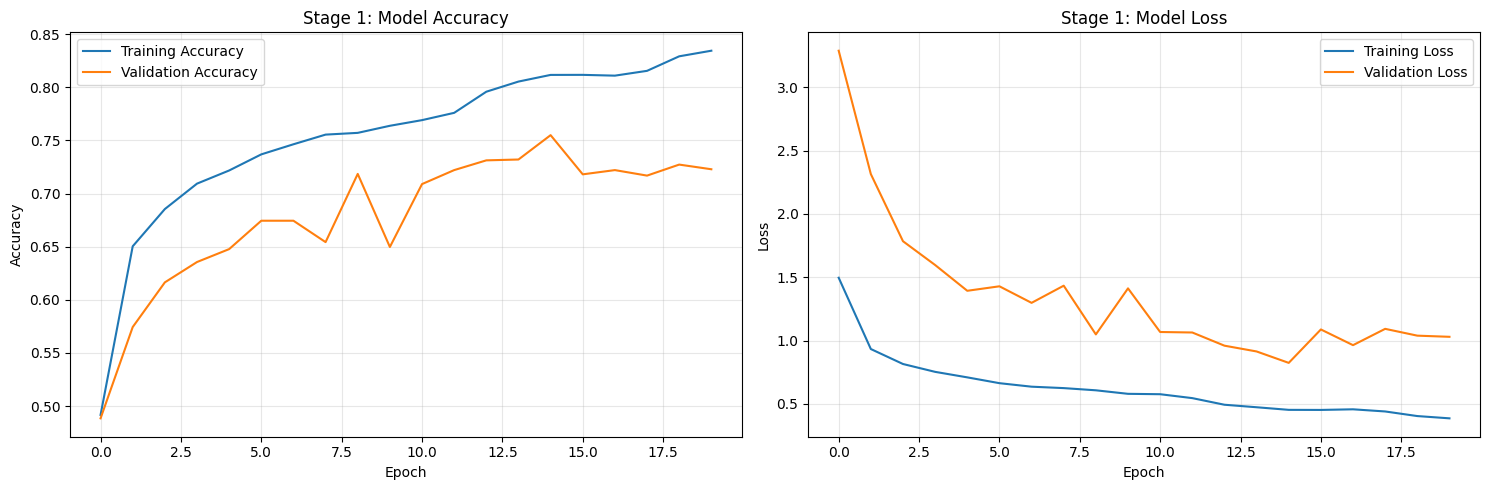

In [92]:
#9 Train Optimized Model

print("\n" + "="*70)
print("TRAINING: Single-Stage (No transfer learning split)")
print(f"Training for {CONFIG['epochs']} epochs")
print("="*70 + "\n")

history_stage1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=CONFIG['epochs'],  # All 20 epochs
    initial_epoch=0,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n✓ Training completed")

# Save training history plot for Stage 1
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'], label='Training Accuracy')
plt.plot(history_stage1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Stage 1: Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'], label='Training Loss')
plt.plot(history_stage1.history['val_loss'], label='Validation Loss')
plt.title('Stage 1: Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['final_model_dir'], 'stage1_training.png'), dpi=150)
plt.show()


In [96]:
#10: 

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)

print("\n📊 Training completed in single stage:")
print("   - MobileNetV2 with partial unfreezing was trained for all 20 epochs")
print("   - No separate fine-tuning stage required")

# Create dummy history_stage2 for compatibility with Cell 11 (plotting)
# This ensures the plotting code doesn't break
class DummyHistory:
    def __init__(self):
        self.history = {
            'loss': [],
            'val_loss': [],
            'accuracy': [],
            'val_accuracy': [],
            'top_3_accuracy': [],
            'val_top_3_accuracy': []
        }

history_stage2 = DummyHistory()

# Load the best model from checkpoints
best_model_path = os.path.join(CONFIG['checkpoint_dir'], 'best_model.keras')
if os.path.exists(best_model_path):
    model = keras.models.load_model(best_model_path)
    print(f"\n✓ Best model loaded from: {best_model_path}")
    print(f"   This model achieved the highest validation accuracy during training")
else:
    print(f"\n⚠ Using current model (checkpoint not found)")

print("\n✅ Ready to proceed to evaluation")


TRAINING COMPLETE

📊 Training completed in single stage:
   - MobileNetV2 with partial unfreezing was trained for all 20 epochs
   - No separate fine-tuning stage required

✓ Best model loaded from: C:\Users\HP\ccmt_training\checkpoints\best_model.keras
   This model achieved the highest validation accuracy during training

✅ Ready to proceed to evaluation



MODEL EVALUATION

157/157 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8304 - loss: 0.5597 - top_3_accuracy: 0.9871 - top_5_accuracy: 0.9979

📊 Final Validation Metrics:
   - Accuracy:  75.50%
   - Top-3 Accuracy: 97.25%
   - Top-5 Accuracy: 99.54%
   - Loss: 0.8243
157/157 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step

🔍 Class Statistics:
   - Total possible classes: 22
   - Classes in validation data: 22
   - Model predicting 22 different classes

📋 Detailed Classification Report:
                           precision    recall  f1-score   support

       Cashew_anthracnose     0.7390    0.7797    0.7588       345
           Cashew_gumosis     0.9286    1.0000    0.9630        78
           Cashew_healthy     0.9880    0.9084    0.9466       273
        Cashew_leaf miner     0.7148    0.7018    0.7083       275
          Cashew_red rust     0.9509    0.9792    0.9648       336
 Cassava_bacterial blight     0.8660    0.7797    0.8206       522
       Cassava_brown spot     0.7261    0.9493    

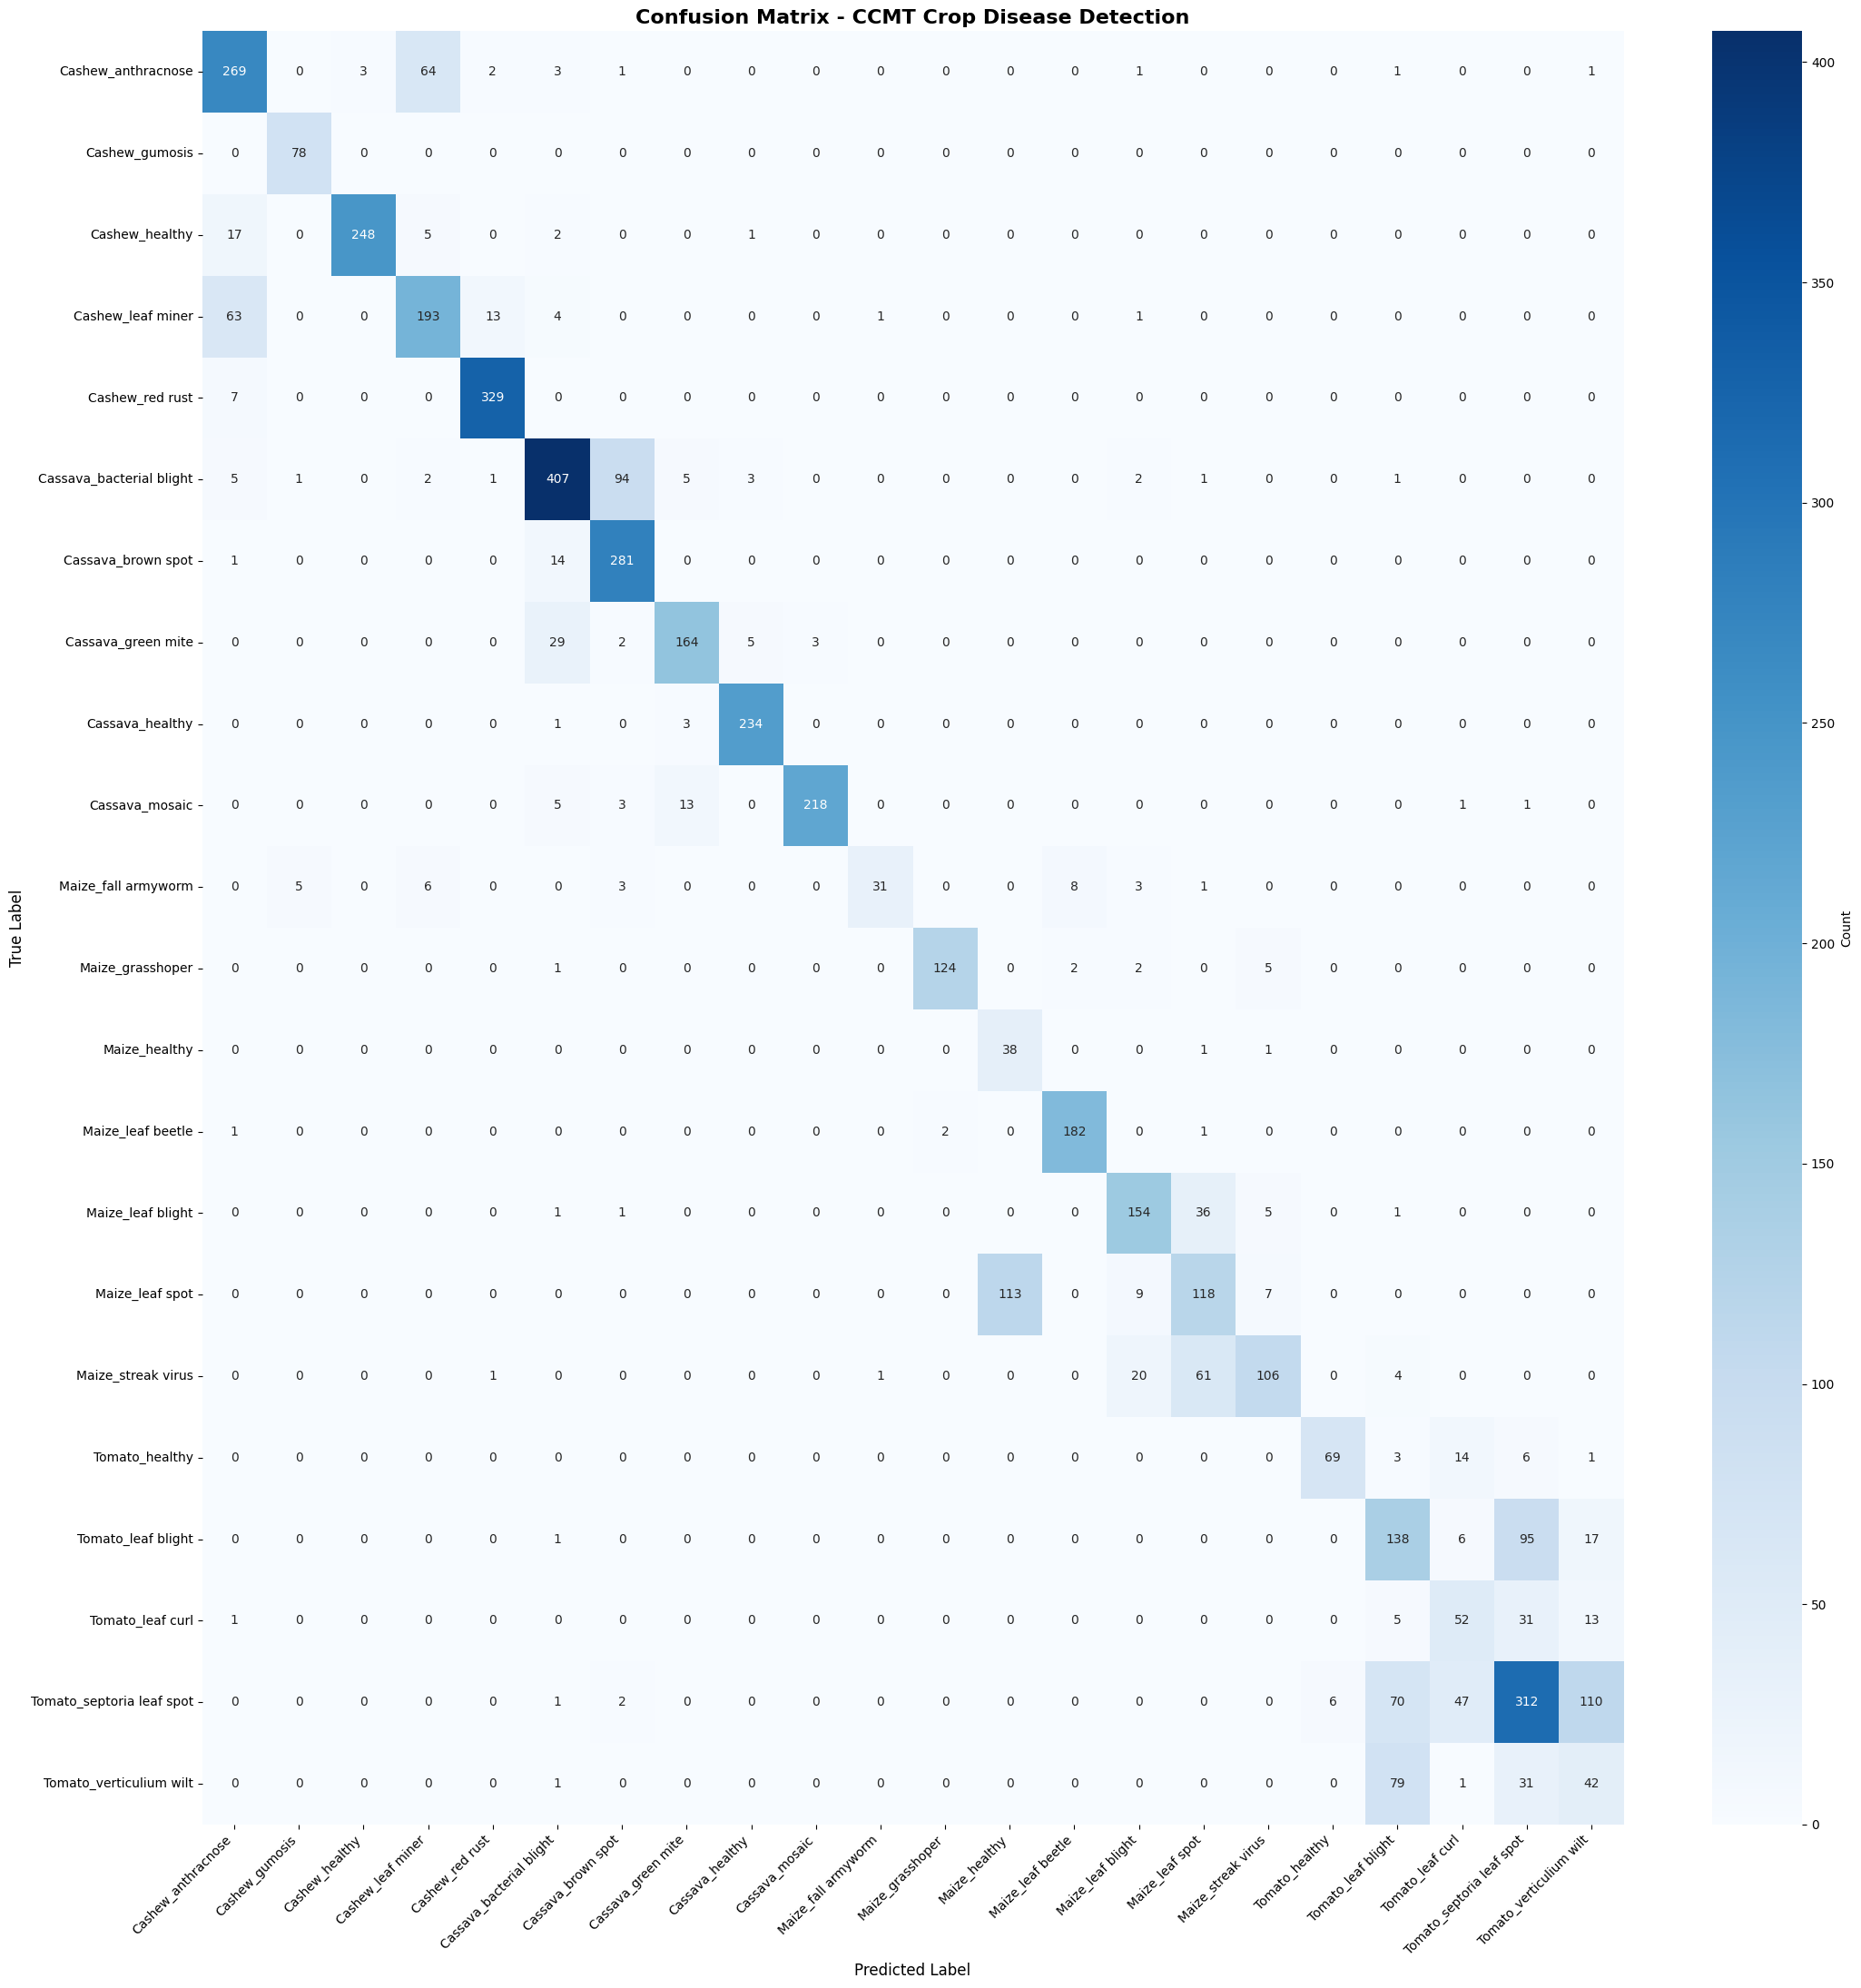

✓ Confusion matrix saved to: C:\Users\HP\ccmt_training\final_model/confusion_matrix.png


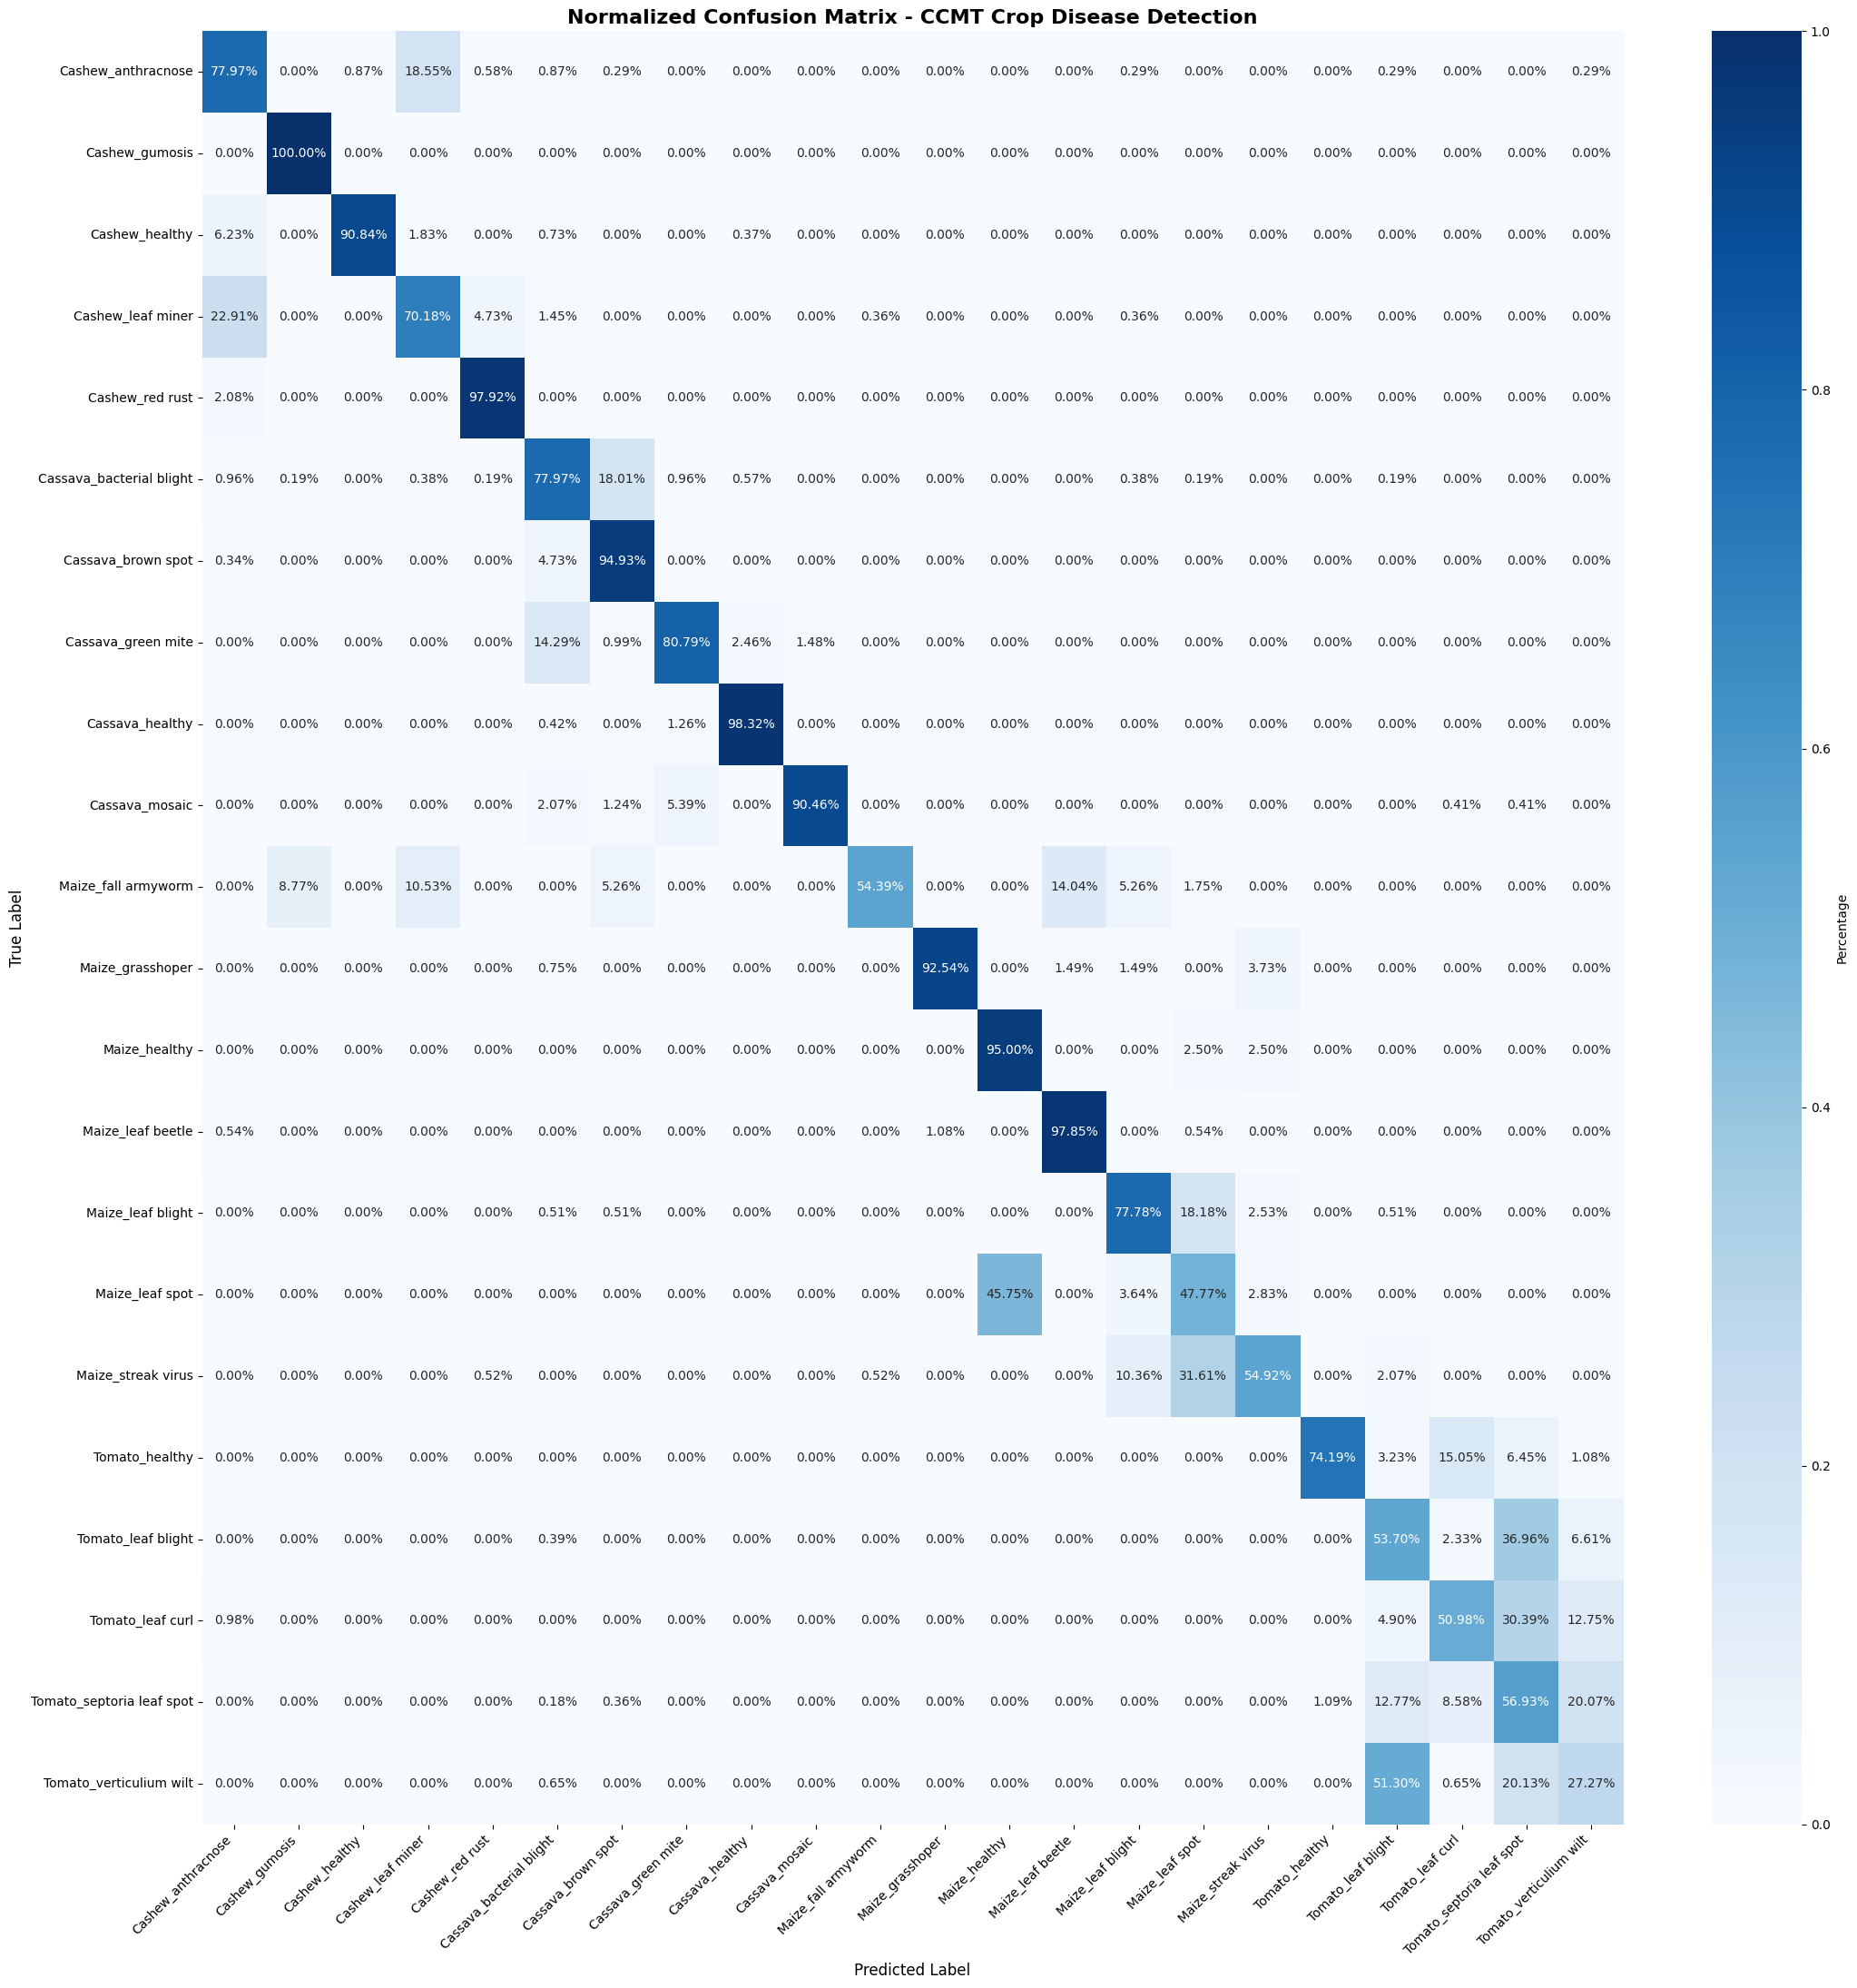

✓ Normalized confusion matrix saved

📊 Per-Class Performance:
   Cashew_anthracnose                      :  77.97%
   Cashew_gumosis                          : 100.00%
   Cashew_healthy                          :  90.84%
   Cashew_leaf miner                       :  70.18%
   Cashew_red rust                         :  97.92%
   Cassava_bacterial blight                :  77.97%
   Cassava_brown spot                      :  94.93%
   Cassava_green mite                      :  80.79%
   Cassava_healthy                         :  98.32%
   Cassava_mosaic                          :  90.46%
   Maize_fall armyworm                     :  54.39%
   Maize_grasshoper                        :  92.54%
   Maize_healthy                           :  95.00%
   Maize_leaf beetle                       :  97.85%
   Maize_leaf blight                       :  77.78%
   Maize_leaf spot                         :  47.77%
   Maize_streak virus                      :  54.92%
   Tomato_healthy                    

In [108]:
# 
# CELL 11: Evaluate Model Performance 

print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70 + "\n")

# Evaluate on validation set
results = model.evaluate(validation_generator, verbose=1)

# Extract metrics (order: loss, accuracy, top_3_accuracy, top_5_accuracy)
val_loss = results[0]
val_accuracy = results[1]
val_top3 = results[2] if len(results) > 2 else 0
val_top5 = results[3] if len(results) > 3 else 0

print(f"\n📊 Final Validation Metrics:")
print(f"   - Accuracy:  {val_accuracy*100:.2f}%")
print(f"   - Top-3 Accuracy: {val_top3*100:.2f}%")
print(f"   - Top-5 Accuracy: {val_top5*100:.2f}%")
print(f"   - Loss: {val_loss:.4f}")

# Get predictions for confusion matrix
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Get class names - use generator's class_indices which is always correct
class_indices = validation_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Get only the class names that actually appear in the data
unique_classes = sorted(np.unique(np.concatenate([y_true, y_pred])))
class_names_filtered = [idx_to_class[i] for i in unique_classes]

print(f"\n🔍 Class Statistics:")
print(f"   - Total possible classes: {len(class_indices)}")
print(f"   - Classes in validation data: {len(unique_classes)}")
print(f"   - Model predicting {len(np.unique(y_pred))} different classes")

# Classification report with filtered classes
print("\n📋 Detailed Classification Report:")
print(classification_report(y_true, y_pred, 
                           labels=unique_classes,
                           target_names=class_names_filtered, 
                           digits=4))

# Save classification report
report_dict = classification_report(y_true, y_pred, 
                                   labels=unique_classes,
                                   target_names=class_names_filtered,
                                   output_dict=True, digits=4)

# Add metadata
report_dict['_metadata'] = {
    'total_classes': len(class_indices),
    'classes_in_validation': len(unique_classes),
    'missing_classes': list(set(class_indices.values()) - set(unique_classes))
}

with open(os.path.join(CONFIG['final_model_dir'], 'classification_report.json'), 'w') as f:
    json.dump(report_dict, f, indent=2)

# Confusion Matrix (use filtered classes)
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
plt.figure(figsize=(max(12, len(class_names_filtered)), max(10, len(class_names_filtered))))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_filtered, yticklabels=class_names_filtered, 
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - CCMT Crop Disease Detection', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['final_model_dir'], 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved to: {CONFIG['final_model_dir']}/confusion_matrix.png")

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(max(12, len(class_names_filtered)), max(10, len(class_names_filtered))))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_names_filtered, yticklabels=class_names_filtered, 
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - CCMT Crop Disease Detection', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['final_model_dir'], 'confusion_matrix_normalized.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Normalized confusion matrix saved")

# Per-class accuracy
print("\n📊 Per-Class Performance:")
for i, class_idx in enumerate(unique_classes):
    class_name = idx_to_class[class_idx]
    class_accuracy = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"   {class_name:40s}: {class_accuracy*100:6.2f}%")

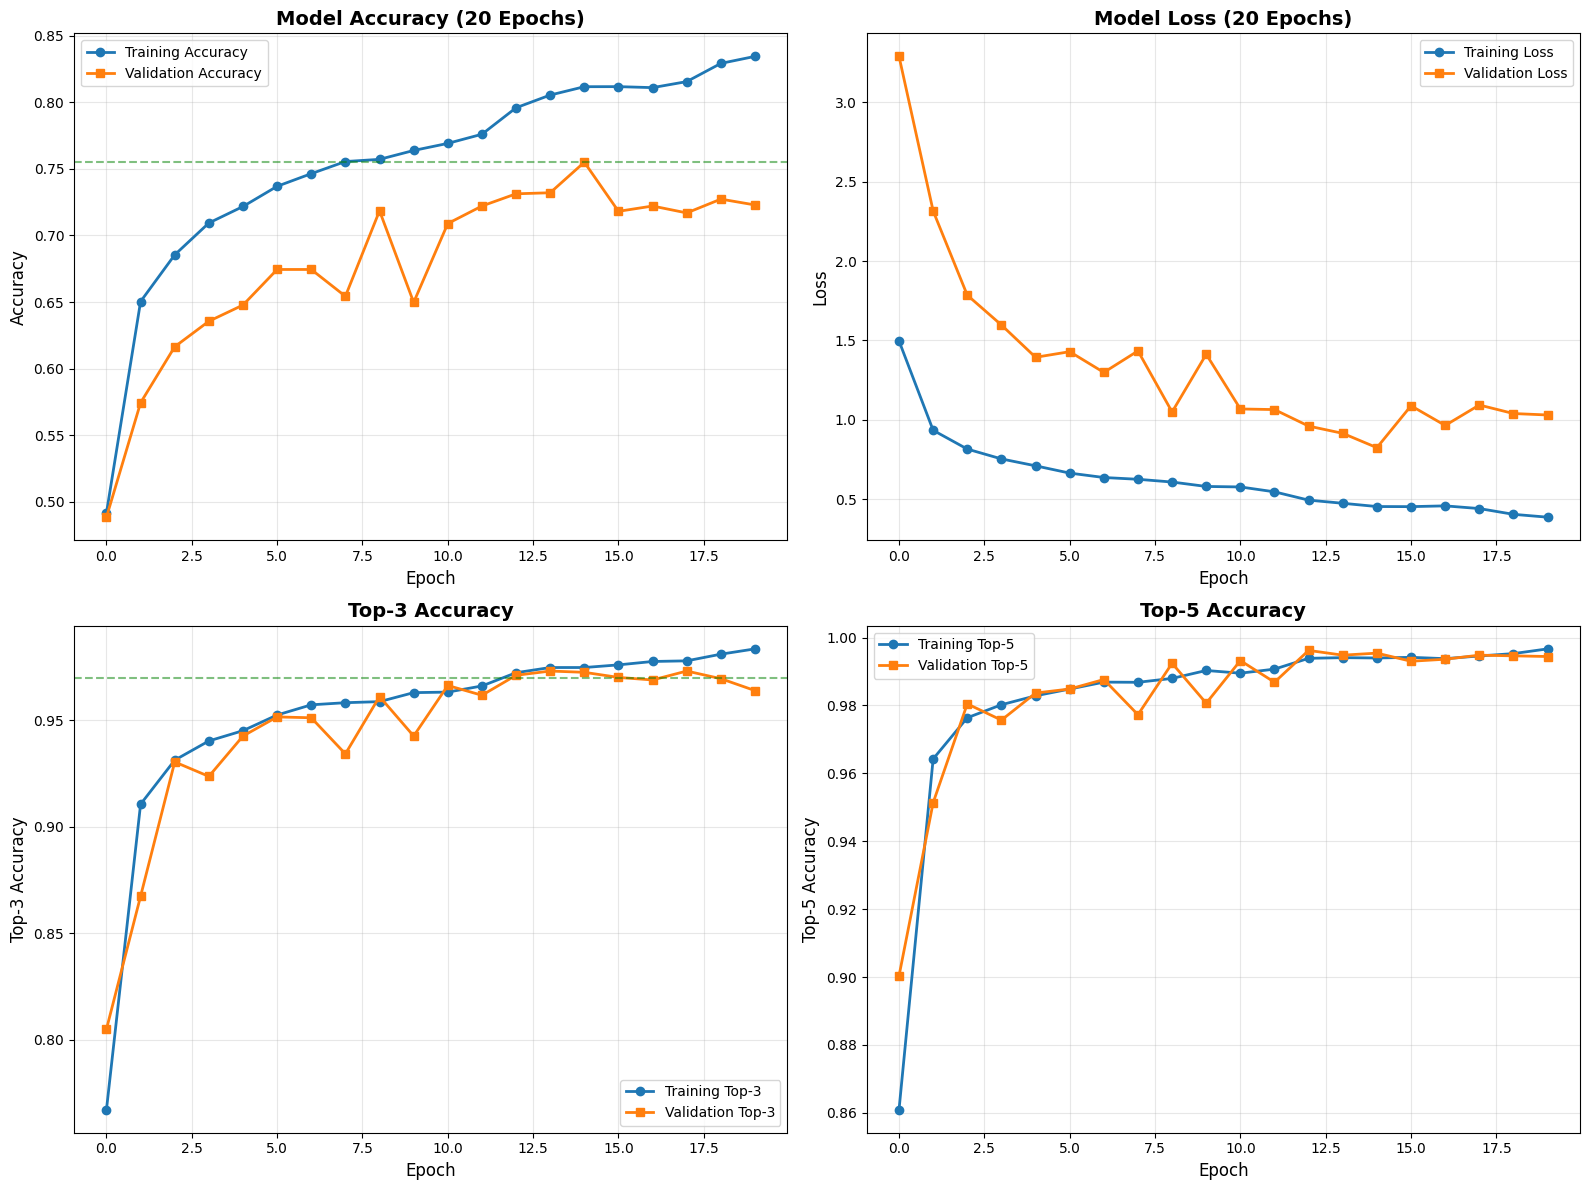

✓ Training history plot saved
✓ Training history CSV saved

📊 Training Summary:
   - Best Validation Accuracy: 75.50%
   - Best Top-3 Accuracy: 97.31%
   - Best Top-5 Accuracy: 99.62%
   - Final Training Accuracy: 83.45%


In [100]:
#12 
#Plot Training History (Single Stage)


# Use only history_stage1 since we didn't do stage 2
training_history = history_stage1.history

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy plot
axes[0, 0].plot(training_history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
axes[0, 0].plot(training_history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
axes[0, 0].set_title('Model Accuracy (20 Epochs)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0.755, color='green', linestyle='--', label='Best: 75.5%', alpha=0.5)

# Loss plot
axes[0, 1].plot(training_history['loss'], label='Training Loss', linewidth=2, marker='o')
axes[0, 1].plot(training_history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[0, 1].set_title('Model Loss (20 Epochs)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Top-3 Accuracy plot
if 'top_3_accuracy' in training_history:
    axes[1, 0].plot(training_history['top_3_accuracy'], label='Training Top-3', linewidth=2, marker='o')
    axes[1, 0].plot(training_history['val_top_3_accuracy'], label='Validation Top-3', linewidth=2, marker='s')
    axes[1, 0].set_title('Top-3 Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Top-3 Accuracy', fontsize=12)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0.97, color='green', linestyle='--', label='Target: 97%', alpha=0.5)

# Top-5 Accuracy plot
if 'top_5_accuracy' in training_history:
    axes[1, 1].plot(training_history['top_5_accuracy'], label='Training Top-5', linewidth=2, marker='o')
    axes[1, 1].plot(training_history['val_top_5_accuracy'], label='Validation Top-5', linewidth=2, marker='s')
    axes[1, 1].set_title('Top-5 Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Top-5 Accuracy', fontsize=12)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['final_model_dir'], 'training_history_complete.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training history plot saved")

# Save training history to CSV
import pandas as pd
history_df = pd.DataFrame(training_history)
history_df.to_csv(os.path.join(CONFIG['final_model_dir'], 'training_history.csv'), index_label='epoch')
print(f"✓ Training history CSV saved")

print("\n📊 Training Summary:")
print(f"   - Best Validation Accuracy: {max(training_history['val_accuracy'])*100:.2f}%")
print(f"   - Best Top-3 Accuracy: {max(training_history['val_top_3_accuracy'])*100:.2f}%")
print(f"   - Best Top-5 Accuracy: {max(training_history['val_top_5_accuracy'])*100:.2f}%")
print(f"   - Final Training Accuracy: {training_history['accuracy'][-1]*100:.2f}%")

In [116]:

# CELL 13: Save Final Model and Create Prediction Function


# Save the model in multiple formats
final_model_keras = os.path.join(CONFIG['final_model_dir'], f"{CONFIG['model_name']}.keras")
final_model_h5 = os.path.join(CONFIG['final_model_dir'], f"{CONFIG['model_name']}.h5")
final_model_saved = os.path.join(CONFIG['final_model_dir'], f"{CONFIG['model_name']}_savedmodel")

# Save in Keras format (recommended)
model.save(final_model_keras)
print(f"✓ Model saved (Keras format): {final_model_keras}")

# Save in H5 format (legacy compatibility)
model.save(final_model_h5)
print(f"✓ Model saved (H5 format): {final_model_h5}")

# Save in SavedModel format (for deployment) 
try:
    model.export(final_model_saved)
    print(f"✓ Model saved (SavedModel format): {final_model_saved}")
except Exception as e:
    print(f"⚠ SavedModel export skipped: {e}")
    print(f"  (This is optional - .keras format is sufficient for Streamlit)")

# Calculate metrics from training history
training_history = history_stage1.history
best_val_accuracy = max(training_history['val_accuracy'])
best_val_top3 = max(training_history['val_top_3_accuracy'])
best_val_top5 = max(training_history['val_top_5_accuracy'])
final_train_accuracy = training_history['accuracy'][-1]

# Get actual class names (filtered to what exists in data)
actual_class_names = [idx_to_class[i] for i in sorted(unique_classes)]

# Save model metadata
metadata = {
    'model_name': CONFIG['model_name'],
    'model_architecture': 'MobileNetV2',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'num_classes': len(unique_classes),
    'class_names': actual_class_names,
    'img_size': list(CONFIG['img_size']),
    'total_epochs': len(training_history['accuracy']),
    'best_val_accuracy': float(best_val_accuracy),
    'best_val_top3_accuracy': float(best_val_top3),
    'best_val_top5_accuracy': float(best_val_top5),
    'final_train_accuracy': float(final_train_accuracy),
    'crops': ['Cashew', 'Cassava', 'Maize', 'Tomato'],
    'training_samples': int(train_generator.samples),
    'validation_samples': int(validation_generator.samples),
    'batch_size': CONFIG['batch_size'],
    'learning_rate': 0.0005,
    'training_strategy': 'Single-stage with partial unfreezing'
}

with open(os.path.join(CONFIG['final_model_dir'], 'model_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Model metadata saved")

# Create inference script
inference_script = '''
"""
CCMT Crop Disease Detection - Inference Script
------------------------------------------------
This script loads the trained model and makes predictions on new images.

Usage:
    python inference.py --image path/to/image.jpg
    
Or use the function directly:
    result = predict_disease('path/to/image.jpg')
"""

import tensorflow as tf
import numpy as np
from PIL import Image
import json
import argparse
import os

def load_model_and_predict(model_path, image_path, class_indices_path):
    """
    Load the trained model and make predictions
    
    Args:
        model_path: Path to the saved .keras model file
        image_path: Path to the image to predict
        class_indices_path: Path to class_indices.json
    
    Returns:
        Dictionary with prediction results
    """
    # Load model
    print(f"Loading model from: {model_path}")
    model = tf.keras.models.load_model(model_path)
    
    # Load class indices
    with open(class_indices_path, 'r') as f:
        class_indices = json.load(f)
    
    # Reverse the dictionary to get class names
    idx_to_class = {v: k for k, v in class_indices.items()}
    
    # Load and preprocess image
    print(f"Loading image: {image_path}")
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    print("Making prediction...")
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    # Get top 5 predictions
    top_5_idx = np.argsort(predictions[0])[-5:][::-1]
    top_5_predictions = [
        {
            'class': idx_to_class.get(idx, f"Unknown_{idx}"),
            'confidence': float(predictions[0][idx]),
            'percentage': f"{float(predictions[0][idx])*100:.2f}%"
        }
        for idx in top_5_idx
    ]
    
    return {
        'predicted_class': idx_to_class.get(predicted_class_idx, f"Unknown_{predicted_class_idx}"),
        'confidence': float(confidence),
        'confidence_percentage': f"{float(confidence)*100:.2f}%",
        'top_5_predictions': top_5_predictions
    }

def predict_disease(image_path, model_dir='.'):
    """
    Simplified prediction function
    
    Args:
        image_path: Path to crop disease image
        model_dir: Directory containing model files (default: current directory)
    
    Returns:
        Prediction results dictionary
    """
    model_path = os.path.join(model_dir, 'ccmt_crop_disease_model.keras')
    class_indices_path = os.path.join(model_dir, 'class_indices.json')
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found: {model_path}")
    if not os.path.exists(class_indices_path):
        raise FileNotFoundError(f"Class indices not found: {class_indices_path}")
    
    return load_model_and_predict(model_path, image_path, class_indices_path)

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='CCMT Crop Disease Detection')
    parser.add_argument('--image', type=str, required=True, help='Path to the crop image')
    parser.add_argument('--model_dir', type=str, default='.', help='Directory containing model files')
    
    args = parser.parse_args()
    
    # Make prediction
    result = predict_disease(args.image, args.model_dir)
    
    # Display results
    print("\\n" + "="*60)
    print("PREDICTION RESULTS")
    print("="*60)
    print(f"\\nPredicted Disease: {result['predicted_class']}")
    print(f"Confidence: {result['confidence_percentage']}")
    print(f"\\nTop 5 Predictions:")
    for i, pred in enumerate(result['top_5_predictions'], 1):
        print(f"  {i}. {pred['class']}: {pred['percentage']}")
    print("="*60 + "\\n")
'''

with open(os.path.join(CONFIG['final_model_dir'], 'inference.py'), 'w') as f:
    f.write(inference_script)

print(f"✓ Inference script created")

# Create README
readme_content = f"""# CCMT Crop Disease Detection Model

## Model Information
- Model: {CONFIG['model_name']}
- Architecture: MobileNetV2
- Training Date: {datetime.now().strftime('%Y-%m-%d')}
- Classes: {len(unique_classes)}
- Crops: Cashew, Cassava, Maize, Tomato

## Performance
- Validation Accuracy: {best_val_accuracy*100:.2f}%
- Top-3 Accuracy: {best_val_top3*100:.2f}%
- Top-5 Accuracy: {best_val_top5*100:.2f}%

## Usage
Load model: tf.keras.models.load_model('ccmt_crop_disease_model.keras')
"""

with open(os.path.join(CONFIG['final_model_dir'], 'README.md'), 'w') as f:
    f.write(readme_content)

print(f"✓ README created")

print("\n" + "="*70)
print("✅ MODEL PACKAGING COMPLETE")
print("="*70)
print(f"\n📦 Location: {CONFIG['final_model_dir']}")
print(f"\n📊 Performance:")
print(f"   - Validation Accuracy: {best_val_accuracy*100:.2f}%")
print(f"   - Top-3 Accuracy: {best_val_top3*100:.2f}%")
print(f"   - Classes: {len(unique_classes)}")
print(f"\n🚀 Ready for Streamlit deployment!")

✓ Model saved (Keras format): C:\Users\HP\ccmt_training\final_model\ccmt_crop_disease_model.keras
✓ Model saved (H5 format): C:\Users\HP\ccmt_training\final_model\ccmt_crop_disease_model.h5
INFO:tensorflow:Assets written to: C:\Users\HP\ccmt_training\final_model\ccmt_crop_disease_model_savedmodel\assets


INFO:tensorflow:Assets written to: C:\Users\HP\ccmt_training\final_model\ccmt_crop_disease_model_savedmodel\assets


Saved artifact at 'C:\Users\HP\ccmt_training\final_model\ccmt_crop_disease_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')]
Output Type:
  TensorSpec(shape=(None, 22), dtype=tf.float32, name=None)
Captures:
  2690615544528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2690615550288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2690994520720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2690994521104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2690994522064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2690994521872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2690994521488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2690994522640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2690994521296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2690994522256: TensorSpec(shape=(), dt

🧪 MODEL TESTING - VERIFY BEFORE DEPLOYMENT

1️⃣ Loading saved model...
✅ Model loaded successfully from final_model directory

2️⃣ Testing on random validation samples...
----------------------------------------------------------------------

🔬 Test #1
--------------------------------------------------
True Disease:      Cashew_anthracnose
Predicted Disease: Cashew_anthracnose
Confidence:        99.97%
Result:            ✅ CORRECT

Top 3 Predictions:
  1. Cashew_anthracnose                        99.97% ✓
  2. Cashew_leaf miner                          0.03%  
  3. Cashew_red rust                            0.00%  


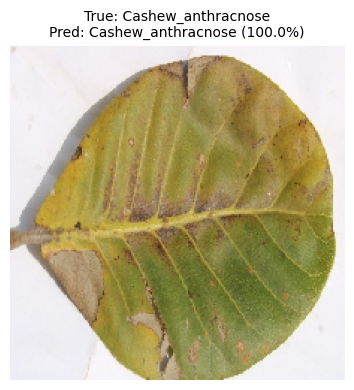


🔬 Test #2
--------------------------------------------------
True Disease:      Cashew_anthracnose
Predicted Disease: Cashew_anthracnose
Confidence:        99.99%
Result:            ✅ CORRECT

Top 3 Predictions:
  1. Cashew_anthracnose                        99.99% ✓
  2. Cashew_leaf miner                          0.01%  
  3. Cashew_red rust                            0.00%  


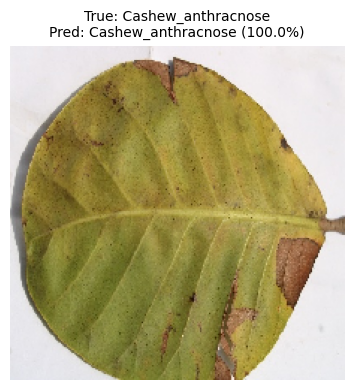


🔬 Test #3
--------------------------------------------------
True Disease:      Cashew_anthracnose
Predicted Disease: Cashew_anthracnose
Confidence:        79.37%
Result:            ✅ CORRECT

Top 3 Predictions:
  1. Cashew_anthracnose                        79.37% ✓
  2. Cashew_leaf miner                         20.51%  
  3. Cashew_red rust                            0.11%  


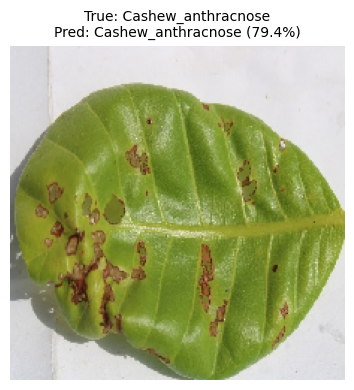


🔬 Test #4
--------------------------------------------------
True Disease:      Cashew_anthracnose
Predicted Disease: Cashew_leaf miner
Confidence:        68.67%
Result:            ❌ INCORRECT

Top 3 Predictions:
  1. Cashew_leaf miner                         68.67%  
  2. Cashew_anthracnose                        29.75% ✓
  3. Cassava_brown spot                         1.50%  


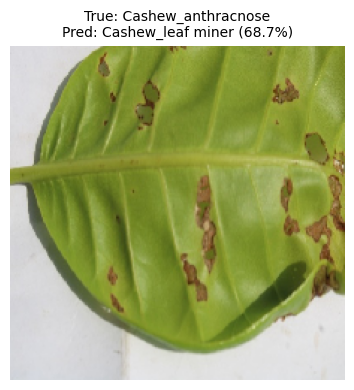


🔬 Test #5
--------------------------------------------------
True Disease:      Cashew_anthracnose
Predicted Disease: Cashew_leaf miner
Confidence:        65.75%
Result:            ❌ INCORRECT

Top 3 Predictions:
  1. Cashew_leaf miner                         65.75%  
  2. Cashew_anthracnose                        34.24% ✓
  3. Cassava_brown spot                         0.01%  


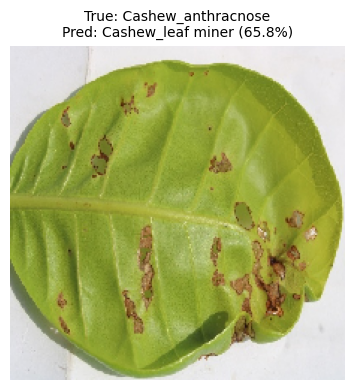


3️⃣ Running batch predictions for accuracy check...
----------------------------------------------------------------------

📊 Quick Test Results (320 samples):
   - Accuracy:       76.88%
   - Top-3 Accuracy: 99.69%
   - Correct: 246/320

📈 Comparison with Training:
   - Training Val Accuracy:   75.50%
   - Test Accuracy:           76.88%
   - Difference:              1.38%
   ✅ Model performance is consistent!

4️⃣ Testing Inference Script Functionality
----------------------------------------------------------------------
Saved test image to: C:\Users\HP\ccmt_training\final_model\test_sample.jpg

Testing inference logic...

✅ Inference script logic works!
   Predicted: Cashew_leaf miner
   Confidence: 55.60%

   Top 5 Predictions:
   1. Cashew_leaf miner: 55.60%
   2. Cashew_anthracnose: 33.76%
   3. Cassava_brown spot: 10.21%
   4. Tomato_septoria leaf spot: 0.21%
   5. Cassava_bacterial blight: 0.15%

   Cleaned up test image

5️⃣ DEPLOYMENT CHECKLIST
✅ Model file (.keras)
✅ Class

In [120]:
# ============================================================================
# CELL 14: Test Prediction (Verify Model Works)
# ============================================================================
import random
from IPython.display import display

print("="*70)
print("🧪 MODEL TESTING - VERIFY BEFORE DEPLOYMENT")
print("="*70)

# Load the saved model
print("\n1️⃣ Loading saved model...")
try:
    test_model = tf.keras.models.load_model(
        os.path.join(CONFIG['final_model_dir'], f"{CONFIG['model_name']}.keras")
    )
    print("✅ Model loaded successfully from final_model directory")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    test_model = None

if test_model is not None:
    # Load class indices
    with open(os.path.join(CONFIG['final_model_dir'], 'class_indices.json'), 'r') as f:
        test_class_indices = json.load(f)
    
    test_idx_to_class = {v: k for k, v in test_class_indices.items()}
    
    print("\n2️⃣ Testing on random validation samples...")
    print("-" * 70)
    
    # Get random samples from validation set
    num_tests = 5
    validation_generator.reset()
    
    # Get a batch
    test_batch, test_labels_batch = next(iter(validation_generator))
    
    for test_num in range(min(num_tests, len(test_batch))):
        print(f"\n🔬 Test #{test_num + 1}")
        print("-" * 50)
        
        # Get single image
        test_img = test_batch[test_num:test_num+1]
        true_label_idx = np.argmax(test_labels_batch[test_num])
        true_label = test_idx_to_class[true_label_idx]
        
        # Make prediction
        prediction = test_model.predict(test_img, verbose=0)
        pred_idx = int(np.argmax(prediction[0]))
        pred_label = test_idx_to_class[pred_idx]
        confidence = float(prediction[0][pred_idx]) * 100
        
        # Display results
        print(f"True Disease:      {true_label}")
        print(f"Predicted Disease: {pred_label}")
        print(f"Confidence:        {confidence:.2f}%")
        
        # Check if correct
        if pred_idx == true_label_idx:
            print("Result:            ✅ CORRECT")
        else:
            print("Result:            ❌ INCORRECT")
        
        # Show top 3 predictions
        top_3_idx = np.argsort(prediction[0])[-3:][::-1]
        print("\nTop 3 Predictions:")
        for i, idx in enumerate(top_3_idx, 1):
            label = test_idx_to_class[idx]
            prob = prediction[0][idx] * 100
            marker = "✓" if idx == true_label_idx else " "
            print(f"  {i}. {label:40s} {prob:6.2f}% {marker}")
        
        # Display image
        img_display = test_img[0]
        img_display = (img_display * 255).astype(np.uint8)
        
        plt.figure(figsize=(4, 4))
        plt.imshow(img_display)
        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)", 
                 fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Overall statistics
    print("\n" + "="*70)
    print("3️⃣ Running batch predictions for accuracy check...")
    print("-" * 70)
    
    # Test on larger sample
    validation_generator.reset()
    num_batches_to_test = 10
    correct = 0
    total = 0
    top3_correct = 0
    
    for i in range(min(num_batches_to_test, len(validation_generator))):
        batch_x, batch_y = next(iter(validation_generator))
        predictions = test_model.predict(batch_x, verbose=0)
        
        for j in range(len(batch_x)):
            true_idx = np.argmax(batch_y[j])
            pred_idx = np.argmax(predictions[j])
            
            if pred_idx == true_idx:
                correct += 1
            
            # Check top-3
            top_3 = np.argsort(predictions[j])[-3:]
            if true_idx in top_3:
                top3_correct += 1
            
            total += 1
    
    test_accuracy = (correct / total) * 100
    test_top3_accuracy = (top3_correct / total) * 100
    
    print(f"\n📊 Quick Test Results ({total} samples):")
    print(f"   - Accuracy:       {test_accuracy:.2f}%")
    print(f"   - Top-3 Accuracy: {test_top3_accuracy:.2f}%")
    print(f"   - Correct: {correct}/{total}")
    
    # Compare with training results
    print(f"\n📈 Comparison with Training:")
    print(f"   - Training Val Accuracy:   {best_val_accuracy*100:.2f}%")
    print(f"   - Test Accuracy:           {test_accuracy:.2f}%")
    print(f"   - Difference:              {abs(best_val_accuracy*100 - test_accuracy):.2f}%")
    
    if abs(best_val_accuracy*100 - test_accuracy) < 5:
        print("   ✅ Model performance is consistent!")
    else:
        print("   ⚠️ Some variation detected (may be due to small test sample)")
    
    # Test inference.py script functionality
    print("\n" + "="*70)
    print("4️⃣ Testing Inference Script Functionality")
    print("-" * 70)
    
    # Save a test image
    test_img_path = os.path.join(CONFIG['final_model_dir'], 'test_sample.jpg')
    test_img_pil = Image.fromarray((test_img[0] * 255).astype(np.uint8))
    test_img_pil.save(test_img_path)
    
    print(f"Saved test image to: {test_img_path}")
    
    # Test using the inference script logic
    print("\nTesting inference logic...")
    
    # Load model
    inference_model = tf.keras.models.load_model(
        os.path.join(CONFIG['final_model_dir'], f"{CONFIG['model_name']}.keras")
    )
    
    # Load class indices
    with open(os.path.join(CONFIG['final_model_dir'], 'class_indices.json'), 'r') as f:
        inf_class_indices = json.load(f)
    
    inf_idx_to_class = {v: k for k, v in inf_class_indices.items()}
    
    # Load and preprocess
    img = Image.open(test_img_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    predictions = inference_model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    # Get top 5
    top_5_idx = np.argsort(predictions[0])[-5:][::-1]
    top_5_predictions = [
        {
            'class': inf_idx_to_class.get(idx, f"Unknown_{idx}"),
            'confidence': float(predictions[0][idx]),
            'percentage': f"{float(predictions[0][idx])*100:.2f}%"
        }
        for idx in top_5_idx
    ]
    
    result = {
        'predicted_class': inf_idx_to_class.get(predicted_class_idx, f"Unknown_{predicted_class_idx}"),
        'confidence': float(confidence),
        'confidence_percentage': f"{float(confidence)*100:.2f}%",
        'top_5_predictions': top_5_predictions
    }
    
    print("\n✅ Inference script logic works!")
    print(f"   Predicted: {result['predicted_class']}")
    print(f"   Confidence: {result['confidence_percentage']}")
    print(f"\n   Top 5 Predictions:")
    for i, pred in enumerate(result['top_5_predictions'], 1):
        print(f"   {i}. {pred['class']}: {pred['percentage']}")
    
    # Cleanup test image
    os.remove(test_img_path)
    print(f"\n   Cleaned up test image")
    
    # Final deployment checklist
    print("\n" + "="*70)
    print("5️⃣ DEPLOYMENT CHECKLIST")
    print("="*70)
    
    checklist = {
        'Model file (.keras)': os.path.exists(os.path.join(CONFIG['final_model_dir'], f"{CONFIG['model_name']}.keras")),
        'Class indices (JSON)': os.path.exists(os.path.join(CONFIG['final_model_dir'], 'class_indices.json')),
        'Model metadata': os.path.exists(os.path.join(CONFIG['final_model_dir'], 'model_metadata.json')),
        'Inference script': os.path.exists(os.path.join(CONFIG['final_model_dir'], 'inference.py')),
        'README file': os.path.exists(os.path.join(CONFIG['final_model_dir'], 'README.md')),
        'Confusion matrix': os.path.exists(os.path.join(CONFIG['final_model_dir'], 'confusion_matrix.png')),
        'Training history': os.path.exists(os.path.join(CONFIG['final_model_dir'], 'training_history.csv')),
    }
    
    all_passed = True
    for item, exists in checklist.items():
        status = "✅" if exists else "❌"
        print(f"{status} {item}")
        if not exists:
            all_passed = False
    
    print("\n" + "="*70)
    if all_passed and test_accuracy > 70:
        print("ALL TESTS PASSED - MODEL READY FOR DEPLOYMENT!")
        print("="*70)
        print("\n📦 Next Steps:")
        print("   1. Copy these files to your Streamlit app directory:")
        print(f"      - {CONFIG['model_name']}.keras")
        print(f"      - class_indices.json")
        print("   2. Run the Streamlit app")
        print("   3. Test with real crop disease images")
        print("\n✅ Your model is production-ready!")
    else:
        print("⚠️ REVIEW NEEDED")
        print("="*70)
        if not all_passed:
            print("   Some files are missing")
        if test_accuracy <= 70:
            print(f"   Test accuracy ({test_accuracy:.2f}%) is below threshold")
        print("\n   Please review before deployment")
    
    print("\n" + "="*70)
    print("TESTING COMPLETE")
    print("="*70)

else:
    print("\n❌ Cannot run tests - model failed to load")
    print("   Please check Cell 13 completed successfully")